/content
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-sdk 0.17.0 requires supervision<1.0.0,>=0.20.0, but you have supervision 0.19.0rc3 which is incompatible.
Taking photo...


<IPython.core.display.Javascript object>

Saved photo to /content/photo.jpg
Displaying the photo taken:


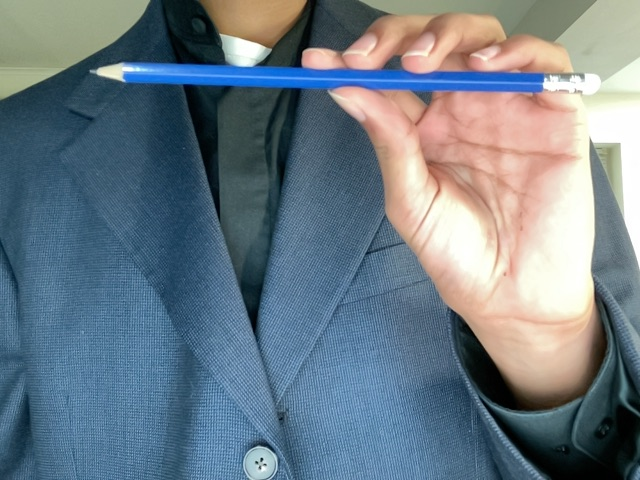

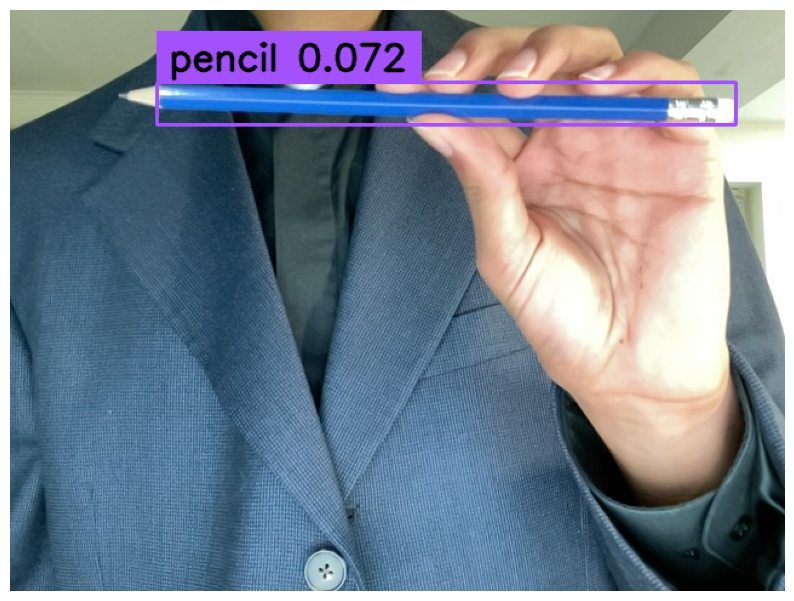

In [4]:
# @title RUN ME! (Left hand side play button)
import os
HOME = os.getcwd()
print(HOME)

!pip install -q inference-gpu[yolo-world]==0.9.12rc1
!pip install -q supervision==0.19.0rc3
!pip install -q gTTS

import cv2
import supervision as sv
from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld
from IPython.display import display, Javascript, Image, Audio
from google.colab.output import eval_js
from base64 import b64decode
from gtts import gTTS  # Import gTTS for text-to-speech

def take_photo(filename='/content/photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';

            // Style the button
            capture.style.fontSize = '24px';  // Make the text larger
            capture.style.padding = '15px 30px';  // Increase button size
            capture.style.backgroundColor = 'green';  // Set background color to green
            capture.style.color = 'white';  // Set text color to white
            capture.style.border = 'none';  // Remove border
            capture.style.borderRadius = '5px';  // Add rounded corners
            capture.style.cursor = 'pointer';  // Change cursor on hover

            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Initialize the YOLO model
model = YOLOWorld(model_id="yolo_world/l")

# Set the classes for the YOLO model
classes = ["pencil", "eraser", "paper", "folder", "binder", "backpack", "book", "headphones"]
model.set_classes(classes)

# Define the source image path (modify this as needed)
SOURCE_IMAGE_PATH = '/content/photo.jpg'  # Path to the captured photo

try:
    filename = SOURCE_IMAGE_PATH

    # Capture only one photo
    print("Taking photo...")
    take_photo(filename)
    print(f'Saved photo to {filename}')

    # Display the photo taken
    print('Displaying the photo taken:')
    display(Image(filename))

    # Load the image for inference with a low confidence threshold
    image = cv2.imread(SOURCE_IMAGE_PATH)
    results = model.infer(image, confidence=0.05)  # Set confidence threshold to 0.05
    detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)  # Apply NMS

    # Create labels for each detection
    labels = [
        f"{classes[class_id]} {confidence:0.3f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # Initialize the annotators
    BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
    LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

    # Annotate the image with bounding boxes
    annotated_image = image.copy()
    annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)

    # Annotate the image with labels
    annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)

    # Plot the annotated image
    sv.plot_image(annotated_image, (10, 10))

    # Text-to-speech for detected labels
    detected_objects = set(classes[class_id] for class_id in detections.class_id)
    if detected_objects:
        text = "".join(detected_objects) + "."
        tts = gTTS(text=text, lang='en')
        audio_file = "/content/detected_objects.mp3"
        tts.save(audio_file)

        # Play the audio file using IPython.display.Audio
        display(Audio(audio_file, autoplay=True))

except Exception as err:
    # Handle errors, e.g., webcam permissions
    print(str(err))